In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plant-disease-recognition-dataset


In [4]:
ls /kaggle/input/plant-disease-recognition-dataset/Train/Train/

Healthy/  Powdery/  Rust/


In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Paths
dataset_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/'
img_size_list = [(256, 256), (200, 200)]

# Function to load and preprocess images
def load_images(img_size, color_mode):
    X, Y = [], []
    class_labels = sorted(os.listdir(dataset_path))

    for label in class_labels:
        class_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # Convert image color
            if color_mode == "greyscale":
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_size)
            img = np.expand_dims(img, axis=-1) if color_mode == "greyscale" else img
            X.append(img)
            Y.append(label)

    X = np.array(X) / 255.0  # Normalize images
    return X, np.array(Y)

# Load dataset in different formats
data = {}
for size in img_size_list:
    for mode in ["greyscale", "RGB"]:
        key = f"{mode}_{size[0]}x{size[1]}"
        print(f"Processing {key}...")
        data[key] = load_images(size, mode)

Processing greyscale_256x256...
Processing RGB_256x256...
Processing greyscale_200x200...
Processing RGB_200x200...


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def train_model(X, Y, img_size, color_mode):
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y)
    Y = to_categorical(Y)

    num_classes = Y.shape[1]  # Get correct number of classes
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Define CNN model
    input_shape = (img_size[0], img_size[1], 1 if color_mode == "greyscale" else 3)
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  # Use Input Layer
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Correct number of output classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model
    model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

    return model, label_encoder

# Train models for all formats
models = {}
for key, (X, Y) in data.items():
    img_size = tuple(map(int, key.split('_')[1].split('x')))
    color_mode = key.split('_')[0]
    print(f"\nTraining Model for {key}")
    models[key] = train_model(X, Y, img_size, color_mode)


Training Model for greyscale_256x256
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.3471 - loss: 8.4102 - val_accuracy: 0.2755 - val_loss: 1.0992
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3421 - loss: 1.0985 - val_accuracy: 0.2755 - val_loss: 1.0997
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3501 - loss: 1.1673 - val_accuracy: 0.2755 - val_loss: 1.0995
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3102 - loss: 1.0985 - val_accuracy: 0.2755 - val_loss: 1.0993
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3274 - loss: 1.0985 - val_accuracy: 0.2755 - val_loss: 1.0997
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3203 - loss: 1.0982 - val_accuracy: 0.2755 - val_loss: 1.0998
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3405 - loss: 1.0982 - val_accuracy: 0.2755 - val_loss: 1.0998
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3545 -

In [7]:
for key, (model, encoder) in models.items():
    print(f"Model {key}: Best Validation Accuracy = {max(model.history.history['val_accuracy'])}")

Model greyscale_256x256: Best Validation Accuracy = 0.36226415634155273
Model RGB_256x256: Best Validation Accuracy = 0.5396226644515991
Model greyscale_200x200: Best Validation Accuracy = 0.36226415634155273
Model RGB_200x200: Best Validation Accuracy = 0.7509434223175049


In [12]:
ls /kaggle/input/plant-disease-recognition-dataset/Test/Test/

Healthy/  Powdery/  Rust/


In [14]:
import os
import cv2
import numpy as np

test_dataset_path = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/'

# Function to preprocess test images
def load_test_images(img_size, color_mode):
    X_test, Y_test = [], []
    class_labels = sorted(os.listdir(test_dataset_path))

    for label in class_labels:
        class_path = os.path.join(test_dataset_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if color_mode == "greyscale":
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to Greyscale
                img = np.expand_dims(img, axis=-1)  # Add channel dimension

            img = cv2.resize(img, img_size)  # Resize to required size
            X_test.append(img)
            Y_test.append(label)

    X_test = np.array(X_test) / 255.0  # Normalize images
    return X_test, np.array(Y_test)

In [15]:
from sklearn.metrics import accuracy_score

# Evaluate models on the test dataset
for key, (model, label_encoder) in models.items():
    img_size = tuple(map(int, key.split('_')[1].split('x')))
    color_mode = key.split('_')[0]

    print(f"\nEvaluating Model: {key}...")

    # Load test images in the same format
    X_test, Y_test = load_test_images(img_size, color_mode)

    # Convert labels to numerical encoding
    Y_test_encoded = label_encoder.transform(Y_test)
    Y_test_encoded = to_categorical(Y_test_encoded)

    # Predict classes
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert one-hot to class index
    Y_test_classes = np.argmax(Y_test_encoded, axis=1)

    # Calculate accuracy
    acc = accuracy_score(Y_test_classes, Y_pred_classes)
    print(f"Accuracy for {key}: {acc:.4f}")


Evaluating Model: greyscale_256x256...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Accuracy for greyscale_256x256: 0.3333

Evaluating Model: RGB_256x256...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Accuracy for RGB_256x256: 0.3333

Evaluating Model: greyscale_200x200...


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
Accuracy for greyscale_200x200: 0.3333

Evaluating Model: RGB_200x200...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Accuracy for RGB_200x200: 0.6200


In [16]:
# prompt: save all four models

import os
for key, (model, encoder) in models.items():
    model_name = f"{key}_model.h5"
    model.save(model_name)
    print(f"Model {key} saved as {model_name}")

    encoder_name = f"{key}_encoder.npy"
    np.save(encoder_name, encoder.classes_)
    print(f"Encoder for {key} saved as {encoder_name}")


Model greyscale_256x256 saved as greyscale_256x256_model.h5
Encoder for greyscale_256x256 saved as greyscale_256x256_encoder.npy


Model RGB_256x256 saved as RGB_256x256_model.h5
Encoder for RGB_256x256 saved as RGB_256x256_encoder.npy


Model greyscale_200x200 saved as greyscale_200x200_model.h5
Encoder for greyscale_200x200 saved as greyscale_200x200_encoder.npy
Model RGB_200x200 saved as RGB_200x200_model.h5
Encoder for RGB_200x200 saved as RGB_200x200_encoder.npy



🔍 Evaluating Model: RGB_200x200...


Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


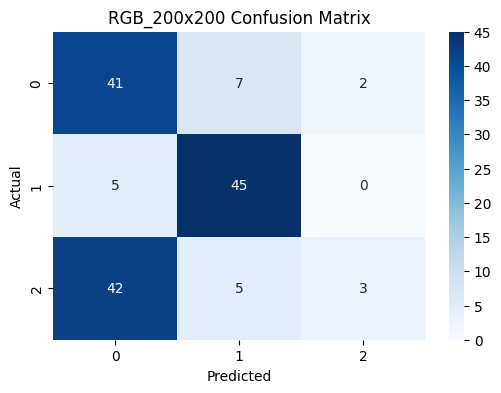

✅ Accuracy for RGB_200x200: 0.5933

🔍 Evaluating Model: RGB_256x256...
Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


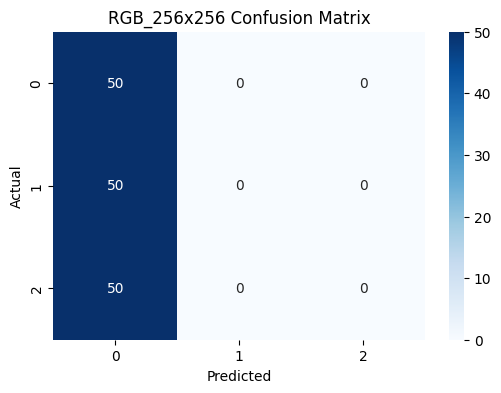

✅ Accuracy for RGB_256x256: 0.3333

🔍 Evaluating Model: greyscale_200x200...


Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_2" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 200, 200, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 200, 200, 3), dtype=float32)
  • training=False
  • mask=None

In [18]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Set up paths and keys
model_keys = ['RGB_200x200', 'RGB_256x256', 'greyscale_200x200', 'greyscale_256x256']
model_paths = [f"/content/{key}_model.h5" for key in model_keys]
encoder_paths = [f"/content/{key}_encoder.npy" for key in model_keys]

# Load test data
test_dir = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/'  # ✅ Your test folder
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming all models expect either 200x200 or 256x256
target_sizes = {
    'RGB_200x200': (200, 200),
    'RGB_256x256': (256, 256),
    'greyscale_200x200': (200, 200),
    'greyscale_256x256': (256, 256)
}

# Store results
accuracies = []
conf_matrices = []

for key, model_path, encoder_path in zip(model_keys, model_paths, encoder_paths):
    print(f"\n🔍 Evaluating Model: {key}...")

    # Load model
    model = load_model(model_path)

    # Load encoder
    encoder_classes = np.load(encoder_path)
    num_classes = len(encoder_classes)

    # Create test generator for specific input shape
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_sizes[key],
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    y_true = test_generator.classes

    # Predict
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    conf_matrices.append(cm.flatten())

    # Accuracy
    acc = np.trace(cm) / np.sum(cm)
    accuracies.append(acc)

    # Optional: Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{key} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"✅ Accuracy for {key}: {acc:.4f}")

# Convert confusion matrices to array for chi-square
conf_array = np.array(conf_matrices)

# Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(conf_array)

print("\n📊 Chi-Square Test Results")
print(f"Chi2 Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_val:.6f}")
print(f"Degrees of Freedom: {dof}")

# Best model
best_index = np.argmax(accuracies)
print(f"\n🏆 Best Model: {model_keys[best_index]} with Accuracy: {accuracies[best_index]:.4f}")


🔍 Evaluating Model: RGB_200x200...
Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


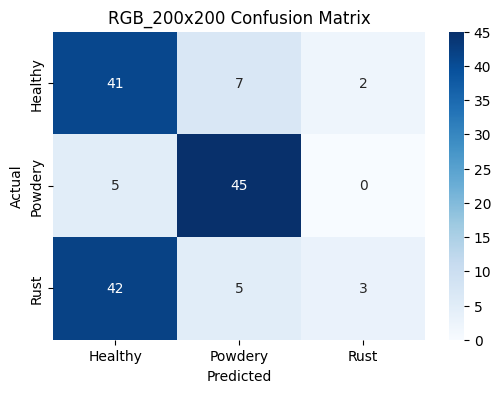

✅ Accuracy for RGB_200x200: 0.5933

🔍 Evaluating Model: RGB_256x256...


Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


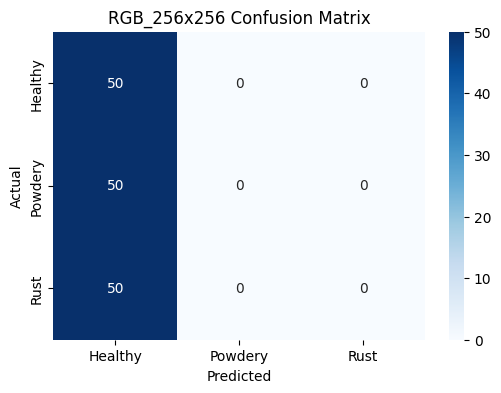

✅ Accuracy for RGB_256x256: 0.3333

🔍 Evaluating Model: greyscale_200x200...


Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


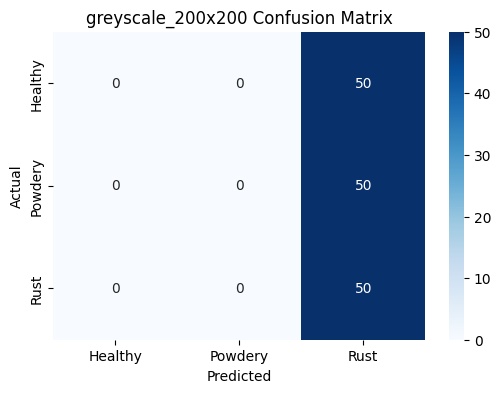

✅ Accuracy for greyscale_200x200: 0.3333

🔍 Evaluating Model: greyscale_256x256...


Found 150 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


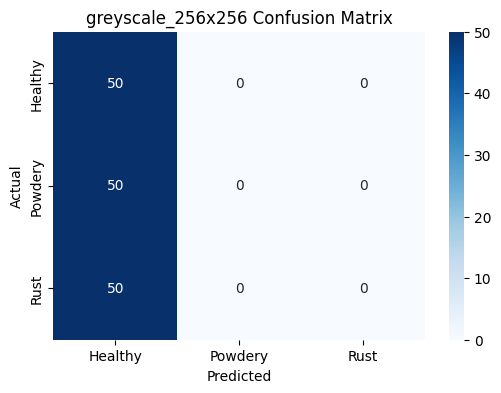

✅ Accuracy for greyscale_256x256: 0.3333

📊 Chi-Square Test Results
Chi2 Statistic     : 60.4351
P-value            : 0.000000
Degrees of Freedom : 4

🏆 Best Model: RGB_200x200 with Accuracy: 0.5933


In [19]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Set up paths and model keys
model_keys = ['RGB_200x200', 'RGB_256x256', 'greyscale_200x200', 'greyscale_256x256']
model_paths = [f"/content/{key}_model.h5" for key in model_keys]
encoder_paths = [f"/content/{key}_encoder.npy" for key in model_keys]

# Dataset path
test_dir = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/'
test_datagen = ImageDataGenerator(rescale=1./255)

# Target input sizes
target_sizes = {
    'RGB_200x200': (200, 200),
    'RGB_256x256': (256, 256),
    'greyscale_200x200': (200, 200),
    'greyscale_256x256': (256, 256)
}

accuracies = []
conf_matrices = []

for key, model_path, encoder_path in zip(model_keys, model_paths, encoder_paths):
    print(f"\n🔍 Evaluating Model: {key}...")

    # Load model and encoder
    model = load_model(model_path)
    encoder_classes = np.load(encoder_path)
    num_classes = len(encoder_classes)

    # Set color mode
    color_mode = 'grayscale' if 'greyscale' in key.lower() else 'rgb'

    # Load test images
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_sizes[key],
        batch_size=32,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False
    )

    # Ground truth
    y_true = test_generator.classes

    # Predictions
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    conf_matrices.append(cm)

    # Accuracy
    acc = np.trace(cm) / np.sum(cm)
    accuracies.append(acc)

    # Plot CM
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder_classes, yticklabels=encoder_classes)
    plt.title(f"{key} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"✅ Accuracy for {key}: {acc:.4f}")

# Stack all confusion matrices
conf_array = np.array(conf_matrices)

# Combine into a single contingency table (sum across models for each class pair)
combined_cm = np.sum(conf_array, axis=0)

# Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(combined_cm)

print("\n📊 Chi-Square Test Results")
print(f"Chi2 Statistic     : {chi2_stat:.4f}")
print(f"P-value            : {p_val:.6f}")
print(f"Degrees of Freedom : {dof}")

# Best model based on accuracy
best_index = np.argmax(accuracies)
print(f"\n🏆 Best Model: {model_keys[best_index]} with Accuracy: {accuracies[best_index]:.4f}")